In [ ]:
def build_vocab(file_path):
    words = set()
    tags = set()
    with open(file_path) as file:
        for line in file:
            line = line.split()
            if line:
                words.add(line[0])
                tags.add(line[1])
    tags.add('PAD_TAG')
    return {'words': words, 'tags': tags}

In [ ]:
vocab = build_vocab('ner/train.txt')

In [ ]:
def get_idx_map(vocab):
    word2idx = {}
    for i, word in enumerate(vocab['words']):
        word2idx[word] = i
    idx2word = {idx: word for word, idx in word2idx.items()}

    tag2idx = {}
    for i, tag in enumerate(vocab['tags']):
        tag2idx[tag] = i
    idx2tag = {idx: tag for tag, idx in tag2idx.items()}
    return word2idx, tag2idx, idx2word, idx2tag

In [ ]:
word2idx, tag2idx, idx2word, idx2tag = get_idx_map(vocab)
tagset_size = len(tag2idx)

In [ ]:
def load_data(file_path):
    sentences = []
    labels = []
    with open(file_path) as file:
        words = []
        tags = []
        for line in file:
            line = line.split()
            if not line and words:
                sentences.append(words)
                labels.append(tags)
                words = []
                tags = []
            else:
                words.append(line[0])
                tags.append(line[1])
    return {'sentences': sentences, 'labels': labels}

In [ ]:
data_train = load_data('ner/train.txt')
data_valid = load_data('ner/valid.txt')
data_test = load_data('ner/test.txt')

In [ ]:
def encode_sentence(sentence, tokenizer):
    input_ids = [101]
    token_start_loc = []
    for token in sentence:
        token_start_loc.append(len(input_ids))
        input_ids += tokenizer.tokenize(token)
    input_ids = tokenizer.convert_tokens_to_ids(input_ids)
    input_ids.append(102)
    return input_ids, token_start_loc

In [ ]:
def batch_encode_sentences(batch_sentences, tokenizer):
    batch_input_ids = []
    batch_token_start_loc = []
    for sentence in batch_sentences:
        input_ids, token_start_loc = encode_sentence(sentence, tokenizer)
        batch_input_ids.append(input_ids)
        batch_token_start_loc.append(token_start_loc)
    return batch_input_ids, batch_token_start_loc

In [ ]:
from numpy import random
import torch

def get_data_loader(sentences, labels, tokenizer, batch_size, shuffle=False, random_seed=0):
    indices = list(range(len(labels)))
    if shuffle:
        random.seed(random_seed)
        random.shuffle(indices)
    for i in range((len(indices) - 1) // batch_size + 1):
        batch_sentences = [sentences[idx] for idx in indices[i*batch_size:(i+1)*batch_size]]
        batch_labels = [labels[idx] for idx in indices[i*batch_size:(i+1)*batch_size]]
        batch_input_ids, batch_token_start_loc = batch_encode_sentences(batch_sentences, tokenizer)

        max_ids_len = max([len(input_ids) for input_ids in batch_input_ids])
        max_sentence_len = max([len(sentence) for sentence in batch_sentences])

        batch_modified_labels = [[tag2idx[tag] for tag in labels] + [-1]*(max_sentence_len-len(labels)) for labels in batch_labels]
        batch_masks = []
        batch_start_masks = []
        for i in range(len(batch_sentences)):
            input_ids = batch_input_ids[i]

            attention_mask = [1]*len(input_ids) + [0]*(max_ids_len-len(input_ids))
            batch_masks.append(attention_mask)

            token_start_loc = batch_token_start_loc[i]
            input_ids += [0]*(max_ids_len-len(input_ids))

            start_mask = [0]*max_ids_len
            for j in range(len(token_start_loc)):
                start_mask[token_start_loc[j]] = 1
            batch_start_masks.append(start_mask)
                
        batch_input_ids = torch.LongTensor(batch_input_ids) 
        batch_modified_labels = torch.LongTensor(batch_modified_labels)
        batch_masks = torch.LongTensor(batch_masks)
        batch_start_masks = torch.LongTensor(batch_start_masks)
        
        yield batch_input_ids, batch_modified_labels, batch_masks, batch_start_masks

In [ ]:
from transformers import BertForTokenClassification
from transformers import AdamW
import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

In [ ]:
import numpy as np

class Metrics:
    def __init__(self, tag2idx):
        self.B2I = dict()
        for tag, idx in tag2idx.items():
            if tag.startswith('B'):
                I_idx = tag2idx['I-'+tag[2:]]
                self.B2I[idx] = I_idx

    def end_of_entity(self, tags, start_loc):
        if start_loc > len(tags) - 1:
            return -1
        if not tags[start_loc] in self.B2I:
            return -1
        end_loc = start_loc + 1
        while not (end_loc >= len(tags) or tags[end_loc] < 0 
                or tags[end_loc] == tag2idx['O'] or tags[end_loc] in self.B2I):
            end_loc += 1
            
        B_idx = tags[start_loc]
        I_idx = self.B2I[B_idx]
        for i in range(start_loc+1, end_loc):
            if tags[i] != I_idx:
                return -1
            
        return end_loc

    def get_ne_loc(self, tags):
        ne_loc = set()
        for i in range(len(tags)):
            if tags[i] in self.B2I:
                j = self.end_of_entity(tags, i)
                if j > 0:
                    ne_loc.add((i, j, tags[i]))
        return ne_loc

    def f1_score(self, preds, labels):
        preds_ne_loc = self.get_ne_loc(preds)
        labels_ne_loc = self.get_ne_loc(labels)
        true_pos = len(preds_ne_loc.intersection(labels_ne_loc))
        precision_weight = len(preds_ne_loc)
        recall_weight = len(labels_ne_loc)
        if precision_weight == 0 or recall_weight == 0:
            return -1, (0, 0, 0, 0)
        precision = true_pos/precision_weight
        recall = true_pos/recall_weight
        if precision + recall == 0:
            return 0, (0, 0, precision_weight, recall_weight)
        f1 = 2*(precision*recall)/(precision+recall)

        return f1, (precision, recall, precision_weight, recall_weight)

    def average_f1_score(self, f1_measurements):
        measurements = np.array(f1_measurements)
        precisions = measurements[:, 0]
        recalls = measurements[:, 1]
        precision_weights = measurements[:, 2]
        recall_weights = measurements[:, 3]
        total_precision_weights = np.sum(precision_weights)
        total_racall_weights = np.sum(recall_weights)
        if total_precision_weights == 0 or total_racall_weights == 0:
            return 0
        precision = np.sum(precisions*precision_weights)/total_precision_weights
        recall = np.sum(recalls*recall_weights)/total_racall_weights
        if (precision+recall) == 0:
            return 0
        f1 = 2*(precision*recall)/(precision+recall)
        return f1

    def accuracy(outputs, labels):
        mask = (labels >= 0)
        n_tokens = int(np.sum(mask))
        
        return np.sum(labels == np.argmax(outputs, axis=1)) / n_tokens


In [ ]:
metrics = Metrics(tag2idx)

In [ ]:
from torch import nn
import torch.nn.functional as F

class BertSeqLabel(nn.Module):
    def __init__(self, bert_type, tagset_size):
        super(BertSeqLabel, self).__init__()
        self.bert = BertForTokenClassification.from_pretrained(bert_type, num_labels=tagset_size)
    
    def forward(self, input_ids, attention_mask, start_masks):
        outputs = self.bert(input_ids, attention_mask)[0]
        reduced_outputs = [outputs[i][start_masks[i]>0, :] for i in range(len(outputs))]
        max_len = max([reduced_output.shape[0] for reduced_output in reduced_outputs])
        reduced_outputs = torch.stack([torch.cat((reduced_output, 
                                                 torch.zeros(max_len - reduced_output.shape[0], 
                                                             reduced_output.shape[1]).cuda()), dim=0) for reduced_output in reduced_outputs])
        return reduced_outputs

In [ ]:
from tqdm.auto import tqdm

def train(model, criterion, metrics, optimizer, data_loader, data_len, schedule_lr=False, scheduler=None, mixed_precision=False, scaler=None):
    model.train()
    train_loss, train_f1 = float('inf'), 0.
    losses = []
    f1_measurements = []
    tqdm_iterator = tqdm(enumerate(data_loader), total=data_len, leave=False, disable=True)
    summary_every = data_len//10
    for i, data in tqdm_iterator:
        input_ids = data[0].cuda()
        attention_mask = data[2].cuda()
        labels = data[1].cuda()
        start_mask = data[3].cuda()

        if mixed_precision:
            with torch.cuda.amp.autocast():
                outputs = model(input_ids, attention_mask, start_mask)
                loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            if schedule_lr:
                # this if condition is added to prevent "UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`."
                if optimizer._step_count >= 1:
                    scheduler.step()
        else:
            outputs = model(input_ids, attention_mask, start_mask)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
            optimizer.zero_grad()
            loss.backward()   
            optimizer.step()
            if schedule_lr:
                scheduler.step()

        losses.append(loss.item())
        outputs, labels = outputs.view(-1, outputs.shape[-1]).data.cpu().numpy(), labels.data.cpu().numpy()
        outputs = np.argmax(outputs, axis=1).flatten()
        labels = labels.flatten()
        padding_loc = labels<0
        outputs[padding_loc] = labels[padding_loc]
        _, batch_measurements = metrics.f1_score(outputs, labels.flatten())
        assert(len(outputs) == len(labels.flatten()))
        f1_measurements.append(batch_measurements)
        
        if i % summary_every == 0:
            train_loss = float(np.mean(losses))
            train_f1 = float(metrics.average_f1_score(f1_measurements))
            tqdm_iterator.set_postfix(loss='{:.4f}'.format(train_loss), f1='{:.4f}'.format(train_f1))
            losses = []
            f1_measurements = []
    return float(train_loss), float(train_f1)

In [ ]:
def evaluate(model, criterion, metrics, data_loader, data_len):
    model.eval()
    losses = []
    f1_measurements = []
    tqdm_iterator = tqdm(enumerate(data_loader), total=data_len, leave=False, disable=True)
    with torch.no_grad():
        for i, data in tqdm_iterator:
            input_ids = data[0].cuda()
            attention_mask = data[2].cuda()
            labels = data[1].cuda()
            start_mask = data[3].cuda()
            outputs = model(input_ids, attention_mask, start_mask)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
            losses.append(loss.item())
            outputs, labels = outputs.view(-1, outputs.shape[-1]).data.cpu().numpy(), labels.data.cpu().numpy()
            outputs = np.argmax(outputs, axis=1).flatten()
            labels = labels.flatten()
            padding_loc = labels<0
            outputs[padding_loc] = labels[padding_loc]
            _, batch_measurements = metrics.f1_score(outputs, labels.flatten())
            assert(len(outputs) == len(labels.flatten()))
            f1_measurements.append(batch_measurements)

    eval_loss = float(np.mean(losses))
    eval_f1 = float(metrics.average_f1_score(f1_measurements))
    
    return float(eval_loss), float(eval_f1)

In [ ]:
from transformers import get_linear_schedule_with_warmup

def train_and_evaluate(model, criterion, metrics, optimizer,
                       train_data, valid_data, tokenizer, batch_size, n_epochs, 
                       schedule_lr=False, mixed_precision=False):
    best_eval_loss = float('inf')
    best_epochs = 0
    summary = {'train': {'loss': [], 'f1': []}, 
               'val': {'loss': [], 'f1': []}}
    print('start training: ')
    train_data_len = (len(train_data['sentences']) - 1) // batch_size + 1
    eval_data_len = (len(valid_data['sentences']) - 1) // batch_size + 1

    scheduler = None
    if schedule_lr:
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, 
                                                    num_training_steps=train_data_len*n_epochs)
    scaler = None
    if mixed_precision:
        scaler = torch.cuda.amp.GradScaler()
        
    for i in range(1, n_epochs + 1):
        print('-'*50)
        print('epoch ', i, ':')
        train_data_loader = get_data_loader(train_data['sentences'], train_data['labels'], tokenizer, batch_size)
        train_loss, train_f1 = train(model, criterion, metrics, optimizer, train_data_loader, train_data_len, schedule_lr, scheduler, mixed_precision, scaler)
        summary['train']['loss'].append(train_loss)
        summary['train']['f1'].append(train_f1)
        print('train loss: {:.4f}; train f1: {:.4f}'.format(train_loss, train_f1))
        
        eval_data_loader = get_data_loader(valid_data['sentences'], valid_data['labels'], tokenizer, batch_size)
        eval_loss, eval_f1 = evaluate(model, criterion, metrics, eval_data_loader, eval_data_len)
        if eval_loss < best_eval_loss:
            best_eval_loss = eval_loss
            best_epochs = i
        summary['val']['loss'].append(eval_loss)
        summary['val']['f1'].append(eval_f1)
        print('eval loss: {:.4f}; eval f1: {:.4f}'.format(eval_loss, eval_f1))
    print('-'*50)
    print('finish training.')
    
    summary['best_eval_loss'] = best_eval_loss
    summary['best_epochs'] = best_epochs
        
    return summary

In [ ]:
from transformers import BertTokenizer
from torch.optim import Adam

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertSeqLabel('bert-base-cased', tagset_size).cuda()
criterion = nn.CrossEntropyLoss(ignore_index = -1)
#optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.02)
optimizer = Adam(model.parameters(), lr=5e-5)

In [ ]:
batch_size = 16
n_epochs = 7

In [ ]:
summary = train_and_evaluate(model, criterion, metrics, optimizer, data_train, data_valid, 
                             tokenizer, batch_size, n_epochs, schedule_lr=True, mixed_precision=False)

start training: 
--------------------------------------------------
epoch  1 :
train loss: 0.0685; train f1: 0.8963
eval loss: 0.0571; eval f1: 0.9214
--------------------------------------------------
epoch  2 :
train loss: 0.0295; train f1: 0.9477
eval loss: 0.0533; eval f1: 0.9327
--------------------------------------------------
epoch  3 :
train loss: 0.0170; train f1: 0.9696
eval loss: 0.0441; eval f1: 0.9457
--------------------------------------------------
epoch  4 :
train loss: 0.0099; train f1: 0.9774
eval loss: 0.0455; eval f1: 0.9488
--------------------------------------------------
epoch  5 :
train loss: 0.0057; train f1: 0.9902
eval loss: 0.0483; eval f1: 0.9492
--------------------------------------------------
epoch  6 :
train loss: 0.0027; train f1: 0.9936
eval loss: 0.0502; eval f1: 0.9488
--------------------------------------------------
epoch  7 :
train loss: 0.0015; train f1: 0.9966
eval loss: 0.0497; eval f1: 0.9513
---------------------------------------------

In [ ]:
import matplotlib.pyplot as plt

def plot_summary(summary):
    data_len = len(summary['train']['loss'])

    plt.figure(figsize=(15,5))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    plt.subplot(121)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.plot(np.arange(1, data_len+1), summary['train']['loss'],  label='train')
    plt.plot(np.arange(1, data_len+1), summary['val']['loss'], label='val')
    plt.legend()
    plt.xlabel('number of epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)

    plt.subplot(122)
    plt.plot(np.arange(1, data_len+1), summary['train']['f1'],  label='train')
    plt.plot(np.arange(1, data_len+1), summary['val']['f1'], label='val')
    plt.legend()
    plt.xlabel('number of epochs', fontsize=12)
    plt.ylabel('f1', fontsize=12)

    plt.show()

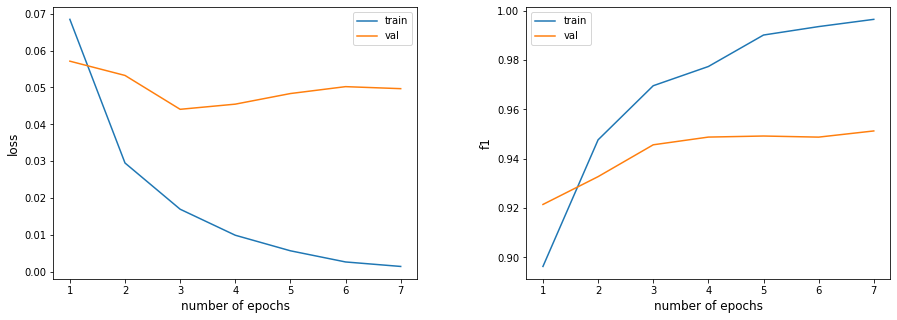

In [ ]:
plot_summary(summary)

In [ ]:
def test(model, criterion, metrics, test_data, tokenizer, batch_size):
    test_data_loader = get_data_loader(test_data['sentences'], test_data['labels'], tokenizer, batch_size)
    test_data_len = (len(test_data['sentences']) - 1) // batch_size + 1
    test_loss, test_f1 = evaluate(model, criterion, metrics, test_data_loader, test_data_len)

    print('test loss: {:.4f}; test f1: {:.4f}'.format(test_loss, test_f1))

In [ ]:
test(model, criterion, metrics, data_test, tokenizer, batch_size)

test loss: 0.1552; test f1: 0.9141
